&#x1F516;Reference

https://www.waxworksmath.com/Authors/G_M/Kuhn/kuhn.html

http://www.ituring.com.cn/article/215742

\begin{exercise}

\end{exercise}
- (a) Given the classification imbalance in hepatic injury status, describe how you would create a training and testing set 
- (b) Which classification statistic would you choose to optimize for this exercise and why?
- (c) Split the data into a training and a testing set, pre-process the data, and build models described in this chapter for the biological predictors and separately for the chemical fingerprint predictors. Which model has the best predictive ability for the biological predictors and what is the optimal performance? Which model has the best predictive ability for the chemical predictors and what is the optimal performance? Based on these results, which set of predictors contains the most information about hepatic toxicity?
- (d) For the optimal models for both the biological and chemical predictors, what are the top five important predictors?
- (e) Now combine the biological and chemical fingerprint predictors into one predictor set. Retrain the same set of predictive models you built from part (c). Which model yields best predictive performance? Is the model performance better than either of the best models from part (c)? What are the top five important predictors for the optimal model? How do these compare with the optimal predictors from each individual predictor set?
- (f) Which model (either model of individual biology or chemical fingerprints or the combined predictor model), if any, would you recommend using to predict compounds’ hepatic toxicity? Explain.

In [1]:
library(AppliedPredictiveModeling)
data(hepatic)
dim(bio);dim(chem);
str(injury)

Warning message:
“package ‘AppliedPredictiveModeling’ was built under R version 3.4.4”

[1] 281 184

[1] 281 192

 Factor w/ 3 levels "Mild","None",..: 1 2 2 3 1 3 2 2 2 2 ...


In [2]:
prop.table(table(injury))

injury
     Mild      None    Severe 
0.5160142 0.3772242 0.1067616 

\begin{remark}
(a) Given the classification imbalance in hepatic injury status, describe how you would create a training and testing set
\end{remark}

In [3]:
any_damage <- as.character(injury)
any_damage[any_damage=="Mild"] = "Yes"
any_damage[any_damage=="Severe"] = "Yes"
any_damage[any_damage=="None"] = "No"
any_damage = factor( any_damage, levels=c("Yes","No") )
prop.table(table(as.data.frame(any_damage)))


      Yes        No 
0.6227758 0.3772242 

In [4]:
#use createDataPartition apply stratified sampling 
library(caret)
trn_id <- createDataPartition(any_damage,p=0.8,list = F)
prop.table(table(as.data.frame(any_damage[trn_id])))
prop.table(table(as.data.frame(any_damage[-trn_id])))

Loading required package: lattice
Loading required package: ggplot2



      Yes        No 
0.6222222 0.3777778 


  Yes    No 
0.625 0.375 

> A data set from the pharmaceutical industry was used to develop a model for predicting compounds probability of causing hepatic injury.

><font color=#3b5998>**Aurelien Geron (2017)**</font> Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner). 


In this case I care more about `recall` $\frac{TP}{TP+FN}$ , because we don't want use compounds which will indeed lead to hepatic injury. We have to capture those compounds mixtures as much as possible. 

&#x25B6; `Missing Values`

In [5]:
any(is.null(bio))

[1] FALSE

&#x25B6; `NearZero Var`

In [6]:
nzv_cols = nearZeroVar(bio)
head(colnames(bio)[nzv_cols])
bio_flt_nzv <- bio[,-nzv_cols]

[1] "Z2"  "Z3"  "Z5"  "Z8"  "Z9"  "Z13"

&#x25B6; `Linear Combos`

In [ ]:
ylinear_cols <- findLinearCombos(bio_flt_nzv)
linear_cols

&#x25B6; `Skewness`

In [80]:
library(e1071)
skew_info  <- apply(bio_flt_nzv,2,skewness)
head(sort(skew_info,decreasing = T))
tail(sort(skew_info,decreasing = T))

Z147      Z17      Z85     Z125     Z145     Z132 
9.240995 8.602032 7.496439 5.840128 5.304804 4.979319

Z105      Z176      Z140      Z169      Z144      Z146 
-5.947533 -6.482465 -7.885383 -7.941488 -8.019982 -9.923829

Using  as id variables


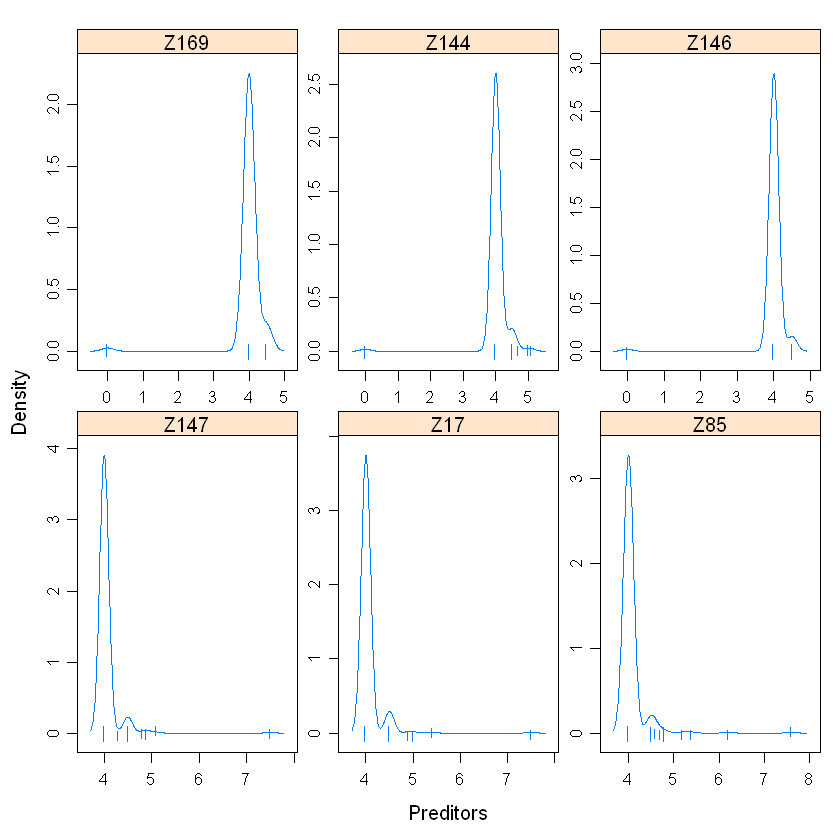

In [96]:
library(psych)
skew_info <-  describe(bio_flt_nzv)
skew_cols <- rownames(skew_info[order(skew_info$skew,decreasing = T),c("vars","skew")])[c(1:3,100:102)]
skew_plt <- bio_flt_nzv[,skew_cols]

library(reshape)
skew_plt <- melt(skew_plt)

library(lattice)
densityplot(~value|variable,data=skew_plt,
            scales = list(x=list(relation="free"),y=list(relation = "free")),
           adjust=1.25,pch="|",xlab="Preditors")

&#x25B6; `Correlations`

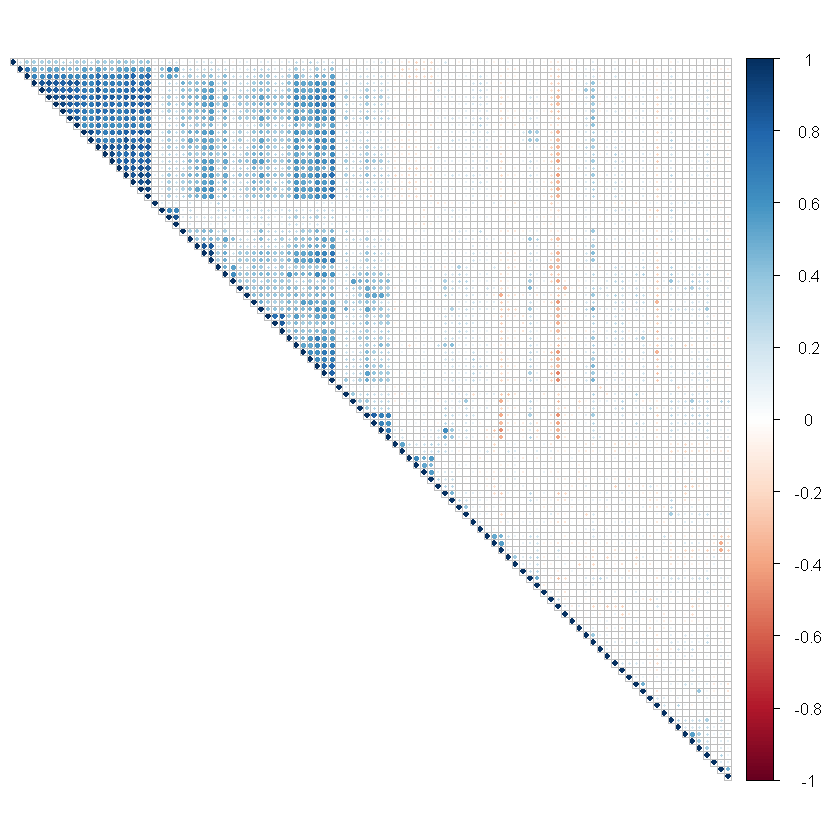

In [73]:
library(corrplot)
cor_info <- cor(bio_flt_nzv)
corrplot(cor_info,type="upper",order="hclust",tl.pos=F)

\begin{remark}
(c) Split the data into a training and a testing set, pre-process the data, and build models described in this chapter for the biological predictors and separately for the chemical fingerprint predictors. Which model has the best predictive ability for the biological predictors and what is the optimal performance? Which model has the best predictive ability for the chemical predictors and what is the optimal performance? Based on these results, which set of predictors contains the most information about hepatic toxicity?
\end{remark}

&#x1F31F;
```r
function pROC:::roc assumes that the second class is the event of interest
```

`# Use the biological predictors`

In [16]:
library(doMC)
registerDoMC(12)
# source("build_AUC_linear_models.R")

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [127]:
options(warn=-1)
X <- bio_flt_nzv
# bio_linear_models <-  build_AUC_linear_models(X,any_damage[trn_id])

In [114]:
df = rbind( data.frame(name="LR", auc=bio_linear_models$glm$auc), data.frame(name="LDA", auc=bio_linear_models$lda$auc),
            data.frame(name="PLSDA", auc=bio_linear_models$plsda$auc), data.frame(name="GLMNET", auc=bio_linear_models$glmnet$auc),
            data.frame(name="NSC", auc=bio_linear_models$nsc$auc) )
# Order our dataframe by performance:
#
df = df[ with( df, order(auc) ), ]
print( "AUC Performance using biological predictors" )
print( df )

[1] "AUC Performance using biological predictors"
    name       auc
4 GLMNET 0.4206723
5    NSC 0.6051681
3  PLSDA 0.6550420
2    LDA 0.9004202
1     LR 0.9529412


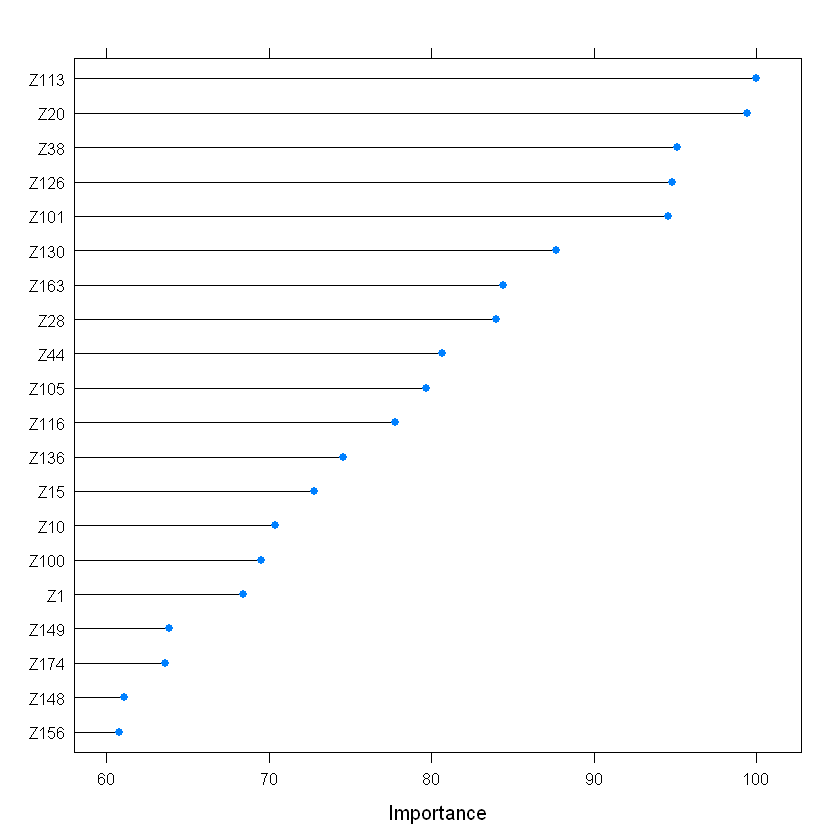

In [116]:
# For the best model (logistic regression) what are the most important predictors:
#
plot(varImp(bio_linear_models$glm$classifier),top=20)

`I made some modification base on the function  Dr.John L. Weatherwax had written`
https://www.waxworksmath.com/Authors/G_M/Kuhn/Code/Chapter12/build_AUC_linear_models.R

In [132]:
build_AUC_linear_models = function(X, y, seed_value=456, build_pls_model=TRUE,trn_rows=trn_id){
    #
    # Builds (using caret's train function) several of the linear models discussed in
    # this chapter of the book optimizing the area-under-the-curve metric (AUC)
    #
    # X [n samples, n features] needs to have zero variance columns removed (use nearZeroVar to remove them) and
    # linear dependent columns removed (use findLinearCombos to remove them)
    #
    # y [n samples, 1] is a two factor vector of predictions with the FIRST factor corresponding to the event of interest
    #
    # Written by:
    # -- 
    # John L. Weatherwax                2009-04-21
    # 
    # email: wax@alum.mit.edu
    # 
    # Please send comments and especially bug reports to the
    # above email address.
    # Modifiedby:
    #Randall Zoeng@20180921
    #-----

    # Set up the train control arguments so that we can compute the area-under-the-curve:
    #
    ctrl = trainControl( 
        summaryFunction=twoClassSummary, 
        classProbs=T,
        index = list(TrainSet = trn_id),
        savePredictions = T,
        method="cv")

    # Logistic Regression Model:
    #
    set.seed(seed_value)
    glm.classifier = train( X, y, method="glm", metric="ROC", trControl=ctrl )
    #     glm.predictions = predict( glm.classifier, X, type="prob" )
    glm.rocCurve = pROC::roc( 
                             response=glm.classifier$pred$obs, 
                             predictor=glm.classifier$pred$Yes, 
                            levels=rev(levels(glm.classifier$pred$obs)))
    glm.auc = glm.rocCurve$auc[1]
    glm=list( classifier=glm.classifier, predictions=glm.classifier$pred$Yes, roc=glm.rocCurve, auc=glm.auc )

    # Linear Discriminant Analysis:
    #
    set.seed(seed_value)
    lda.classifier = train( X, y, method="lda", preProc=c("center","scale"), metric="ROC", trControl=ctrl )
    #     lda.predictions = predict( lda.classifier, X, type="prob" ) # <~ returns probability of "Yes" (event of interest) & "No"
    lda.rocCurve = pROC::roc( 
                             response=lda.classifier$pred$obs, 
                             predictor=lda.classifier$pred$Yes,
                             levels=rev(levels(lda.classifier$pred$obs)))
    lda.auc = lda.rocCurve$auc[1]
    lda=list( classifier=lda.classifier, predictions=lda.classifier$pred$Yes, roc=lda.rocCurve, auc=lda.auc )

    # Partial Least Squares Discriminant Analysis (this can take a very long time on the churn data set):
    #
    if( build_pls_model ){
        set.seed(seed_value)
        plsda.classifier = train( X, y, method="pls", tuneGrid=expand.grid(.ncomp=1:10), preProc=c("center","scale"), metric="ROC", trControl=ctrl )
    #         plsda.predictions = predict( plsda.classifier, X, type="prob" )
        plsda.rocCurve = pROC::roc( 
                                   response=plsda.classifier$pred$obs, 
                                   predictor=plsda.classifier$pred$Yes,
                                   levels=rev(levels(plsda.classifier$pred$obs)))
        plsda.auc = plsda.rocCurve$auc[1]
        plsda=list( classifier=plsda.classifier, predictions=plsda.classifier$pred$Yes, roc=plsda.rocCurve, auc=plsda.auc )
    }

    # Penalized Methods:
    #
    glmnGrid = expand.grid(.alpha=c(0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0), .lambda=seq( 0.01, 0.2, length=40))
    set.seed(seed_value)
    glmnet.classifier = train( X, y, method="glmnet", tuneGrid=glmnGrid, preProc=c("center","scale"), metric="ROC", trControl=ctrl )
    #     glmnet.predictions = predict( glmnet.classifier, X, type="prob" )
    glmnet.rocCurve = pROC::roc( 
                                response=glmnet.classifier$pred$obs, 
                                predictor=glmnet.classifier$pred$Yes,
                                levels=rev(levels(glmnet.classifier$pred$obs)))
    glmnet.auc = glmnet.rocCurve$auc[1]
    glmnet=list( classifier=glmnet.classifier, predictions=glmnet.classifier$pred$Yes, roc=glmnet.rocCurve, auc=glmnet.auc )

    # Nearest shrunken Centroids:
    #
    nscGrid = expand.grid(.threshold=0:25)
    set.seed(seed_value)
    nsc.classifier = train( X, y, method="pam", tuneGrid=nscGrid, preProc=c("center","scale"), metric="ROC", trControl=ctrl )
#     nsc.predictions = predict( nsc.classifier, X, type="prob" )
    nsc.rocCurve = pROC::roc( 
                             response=nsc.classifier$pred$obs, 
                             predictor=nsc.classifier$pred$Yes,
                             levels=rev(levels(nsc.classifier$pred$obs)))
    nsc.auc = nsc.rocCurve$auc[1]
    nsc=list( classifier=nsc.classifier, predictions=nsc.classifier$pred$Yes, roc=nsc.rocCurve, auc=nsc.auc )

    result = list( glm=glm, lda=lda, glmnet=glmnet, nsc=nsc )
    if( build_pls_model ){ result = c(result, list(plsda=plsda)) }
    return( result )

}

In [133]:
bio_linear_models <-  build_AUC_linear_models(X,any_damage,trn_rows=trn_id)
bio_linear_models

11

$glm
$glm$classifier
Generalized Linear Model 

281 samples
102 predictors
  2 classes: 'Yes', 'No' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 225 
Resampling results:

  ROC        Sens  Spec     
  0.4952381  0.6   0.4285714


$glm$predictions
 [1] 1.054764e-06 2.324576e-08 9.999988e-01 1.000000e+00 3.867810e-01
 [6] 1.335627e-01 9.091622e-01 9.999876e-01 1.000000e+00 5.704861e-01
[11] 6.093065e-09 2.984600e-03 2.646937e-01 3.727040e-01 1.513241e-04
[16] 1.473736e-04 1.245946e-03 8.789796e-01 2.721287e-01 9.999798e-01
[21] 1.114022e-01 9.998357e-01 4.315655e-01 7.072714e-02 2.052715e-02
[26] 3.290489e-03 9.995254e-01 9.994916e-01 9.755191e-01 4.870069e-03
[31] 1.000000e+00 9.977652e-01 1.589910e-09 1.000000e+00 1.000000e+00
[36] 5.724413e-01 9.998552e-01 1.000000e+00 9.999889e-01 9.999766e-01
[41] 8.331683e-01 7.511162e-01 1.000000e+00 9.962748e-01 9.999757e-01
[46] 9.967096e-01 5.487615e-04 6.333376e-10 3.868308e-02 9.999683e-01
[51] 8.450205

In [134]:
df = rbind( data.frame(name="LR", auc=bio_linear_models$glm$auc), data.frame(name="LDA", auc=bio_linear_models$lda$auc),
            data.frame(name="PLSDA", auc=bio_linear_models$plsda$auc), data.frame(name="GLMNET", auc=bio_linear_models$glmnet$auc),
            data.frame(name="NSC", auc=bio_linear_models$nsc$auc) )
# Order our dataframe by performance:
#
df = df[ with( df, order(auc,decreasing = T) ), ]
print( "AUC Performance using biological predictors" )
print( df )

[1] "AUC Performance using biological predictors"
    name       auc
4 GLMNET 0.5540978
2    LDA 0.5061224
1     LR 0.5047619
5    NSC 0.5010566
3  PLSDA 0.4993333


> Unfortunately, the performance get worse. The original results are:

| MDL    | AUC       |
|--------|-----------|
| LR     | 0.9529412 |
| LDA    | 0.9004202 |
| PLSDA  | 0.6550420 |
| NSC    | 0.6051681 |
| GLMNET | 0.4206723 |


`Let's use Logistic Regression as example to feagure out `

&#x1F52E; `Original  model by Dr.John`

In [18]:
library(caret)
ctrl <- trainControl(method = "cv",
                    summaryFunction=twoClassSummary,
                     classProbs=T)

set.seed(456)
fit_glm_orig <- train(x = bio_flt_nzv,y=any_damage,method = "glm",trControl=ctrl)
pred_glm <- predict(fit_glm_orig,newdata = bio_flt_nzv,type="prob")
roc_glm <- pROC::roc(response = any_damage,predictor = pred_glm[,1])
auc_glm <- roc_glm$auc[1]
glm <- list(classifier=fit_glm_orig, predictions=pred_glm, roc=roc_glm, auc=auc_glm)

print(glm)

$classifier
Generalized Linear Model 

281 samples
102 predictors
  2 classes: 'Yes', 'No' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 254, 253, 252, 254, 253, 252, ... 
Resampling results:

  ROC        Sens      Spec     
  0.5459834  0.624183  0.4336364


$predictions
             Yes           No
1   3.739086e-01 6.260914e-01
2   2.638093e-01 7.361907e-01
3   7.483222e-04 9.992517e-01
4   9.999784e-01 2.159033e-05
5   6.099497e-01 3.900503e-01
6   9.766588e-01 2.334117e-02
7   3.443211e-01 6.556789e-01
8   7.930088e-01 2.069912e-01
9   1.399799e-02 9.860020e-01
10  5.578270e-03 9.944217e-01
11  6.496999e-02 9.350300e-01
12  6.879388e-01 3.120612e-01
13  8.274417e-01 1.725583e-01
14  7.148425e-09 1.000000e+00
15  4.416650e-01 5.583350e-01
16  9.471618e-01 5.283825e-02
17  7.774628e-01 2.225372e-01
18  8.251676e-01 1.748324e-01
19  1.300447e-01 8.699553e-01
20  3.989171e-01 6.010829e-01
21  5.742307e-01 4.257693e-01
22  8.092468e-01 1.907532e-0

In [19]:
pROC::roc(response = any_damage,predictor = pred_glm[,1],levels = rev(levels(any_damage)))


Call:
roc.default(response = any_damage, predictor = pred_glm[, 1],     levels = rev(levels(any_damage)))

Data: pred_glm[, 1] in 106 controls (any_damage No) < 175 cases (any_damage Yes).
Area under the curve: 0.8975

In [20]:
confusionMatrix(fit_glm_orig)

Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction  Yes   No
       Yes 38.8 21.4
       No  23.5 16.4
                            
 Accuracy (average) : 0.5516


In [21]:
confusionMatrix(reference = any_damage,data = predict(fit_glm_orig,newdata = bio_flt_nzv) )

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes 157  29
       No   18  77
                                          
               Accuracy : 0.8327          
                 95% CI : (0.7839, 0.8744)
    No Information Rate : 0.6228          
    P-Value [Acc > NIR] : 1.123e-14       
                                          
                  Kappa : 0.6366          
 Mcnemar's Test P-Value : 0.1447          
                                          
            Sensitivity : 0.8971          
            Specificity : 0.7264          
         Pos Pred Value : 0.8441          
         Neg Pred Value : 0.8105          
             Prevalence : 0.6228          
         Detection Rate : 0.5587          
   Detection Prevalence : 0.6619          
      Balanced Accuracy : 0.8118          
                                          
       'Positive' Class : Yes             
                                          

In [72]:
library(caret)
ctrl <- trainControl(method="repeatedcv",number=10,repeats = 10,
                    summaryFunction=twoClassSummary,
                     classProbs=T,savePredictions = T)

set.seed(456)
fit_glm_orig <- train(x = bio_flt_nzv,y=any_damage,method = "glm",trControl=ctrl)
pred_glm <- predict(fit_glm_orig,newdata = bio_flt_nzv,type="prob")
roc_glm <- pROC::roc(response = any_damage,predictor = pred_glm[,1])
auc_glm <- roc_glm$auc[1]
glm <- list(classifier=fit_glm_orig, predictions=pred_glm, roc=roc_glm, auc=auc_glm)

In [73]:
fit_glm_orig

Generalized Linear Model 

281 samples
102 predictors
  2 classes: 'Yes', 'No' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 254, 253, 252, 254, 253, 252, ... 
Resampling results:

  ROC        Sens       Spec     
  0.5284226  0.6166667  0.4132727


In [30]:
pred_glm <- predict(fit_glm_orig,newdata = bio_flt_nzv,type="prob")
pROC::roc(response = any_damage,predictor = pred_glm[,1])


Call:
roc.default(response = any_damage, predictor = pred_glm[, 1])

Data: pred_glm[, 1] in 175 controls (any_damage Yes) > 106 cases (any_damage No).
Area under the curve: 0.8975

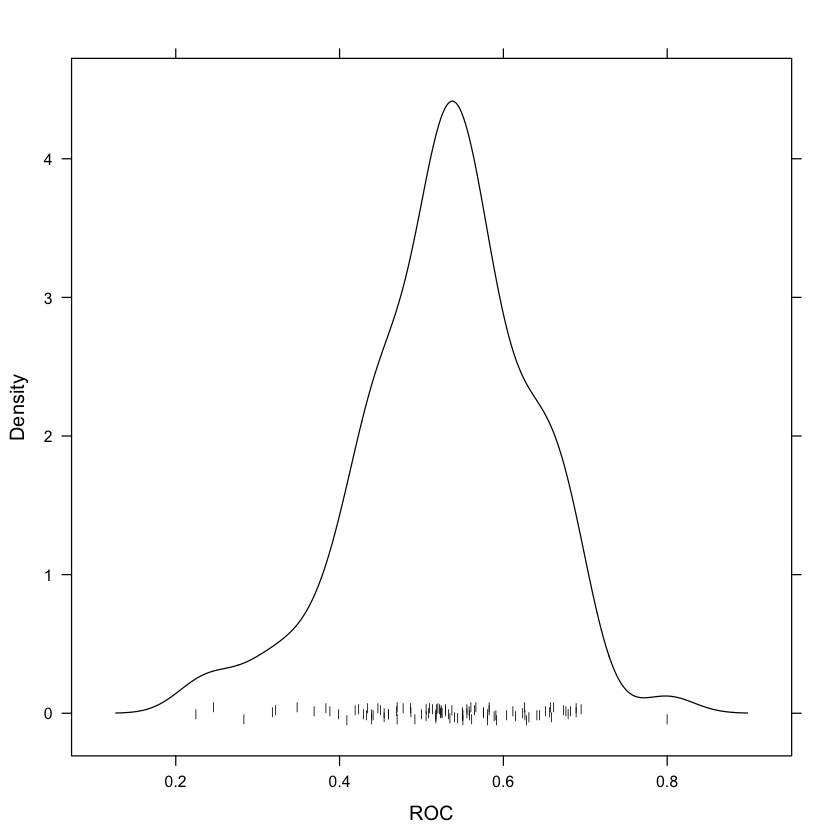

In [74]:
trellis.par.set(caretTheme())
densityplot(fit_glm_orig, pch = "|")

In [36]:
df <- cbind(bio_flt_nzv,as.data.frame(any_damage))
fit_lm <- glm(any_damage~.,data=df,family = binomial(link="logit")) 


In [37]:
summary(fit_lm)


Call:
glm(formula = any_damage ~ ., family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1959  -0.6653  -0.1364   0.4226   2.4416  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -35.93186   27.18949  -1.322 0.186323    
Z1            1.73558    0.95517   1.817 0.069210 .  
Z4            0.84485    0.89027   0.949 0.342630    
Z6           -0.52795    1.13656  -0.465 0.642278    
Z7           -1.35189    0.77652  -1.741 0.081691 .  
Z10           1.67324    1.25363   1.335 0.181970    
Z11          -0.82900    1.01931  -0.813 0.416049    
Z12           0.63389    1.38225   0.459 0.646527    
Z15          -1.44195    0.60876  -2.369 0.017853 *  
Z17          -0.20794    1.51948  -0.137 0.891152    
Z18           1.23666    1.22991   1.005 0.314661    
Z19           0.92847    0.85419   1.087 0.277052    
Z20          -2.84602    1.07669  -2.643 0.008210 ** 
Z21          -1.18966    0.

In [43]:
fit_lm$fitted.values

1            2            3            4            5            6 
6.260914e-01 7.361907e-01 9.992517e-01 2.159033e-05 3.900503e-01 2.334117e-02 
           7            8            9           10           11           12 
6.556789e-01 2.069912e-01 9.860020e-01 9.944217e-01 9.350300e-01 3.120612e-01 
          13           14           15           16           17           18 
1.725583e-01 1.000000e+00 5.583350e-01 5.283825e-02 2.225372e-01 1.748324e-01 
          19           20           21           22           23           24 
8.699553e-01 6.010829e-01 4.257693e-01 1.907532e-01 5.415517e-01 1.154473e-01 
          25           26           27           28           29           30 
2.804059e-01 1.367939e-01 2.348876e-02 9.808848e-01 7.012563e-01 9.945083e-01 
          31           32           33           34           35           36 
4.099615e-01 2.220992e-02 2.629917e-01 9.950048e-01 5.177642e-01 7.093739e-02 
          37           38           39           40           41           42 
5.762108e-02 2.071917e-03 3.647759e-01 2.856051e-01 1.093904e-01 9.983353e-01 
          43           44           45           46           47           48 
7.835064e-01 3.222527e-01 1.000000e+00 5.168154e-02 3.891538e-01 8.116364e-04 
          49           50           51           52           53           54 
6.989097e-01 6.398624e-01 5.541456e-01 4.138031e-01 5.639050e-01 3.871274e-01 
          55           56           57           58           59           60 
2.555099e-02 9.987744e-01 2.077242e-01 9.545128e-01 5.075675e-10 2.222851e-01 
          61           62           63           64           65           66 
9.864259e-01 3.642231e-01 1.435488e-01 2.129380e-01 6.235363e-02 5.689708e-01 
          67           68           69           70           71           72 
5.808793e-01 9.145771e-01 9.998747e-01 8.568912e-01 5.320234e-03 8.607038e-02 
          73           74           75           76           77           78 
9.297229e-01 9.999999e-01 3.175334e-01 1.566194e-01 8.084592e-02 5.330205e-01 
          79           80           81           82           83           84 
2.072902e-01 9.051896e-01 3.685969e-01 3.902358e-03 9.066147e-01 5.868343e-01 
          85           86           87           88           89           90 
9.428144e-01 6.355476e-01 9.903160e-01 5.663818e-01 2.943276e-01 9.984577e-01 
          91           92           93           94           95           96 
7.166497e-01 1.304894e-02 2.454561e-01 7.519736e-01 3.247506e-01 2.548250e-01 
          97           98           99          100          101          102 
1.099893e-05 2.752395e-03 1.312377e-01 9.972939e-01 3.466731e-01 3.225194e-01 
         103          104          105          106          107          108 
9.999982e-01 6.634723e-04 9.796286e-01 2.806268e-01 9.999963e-01 1.175042e-01 
         109          110          111          112          113          114 
1.102471e-01 8.833808e-03 9.653770e-01 9.752784e-01 7.129153e-01 5.945274e-01 
         115          116          117          118          119          120 
6.091708e-05 5.498570e-01 8.185857e-01 4.432202e-01 7.676591e-02 8.982854e-01 
         121          122          123          124          125          126 
8.030570e-01 2.081832e-01 8.990891e-01 4.212774e-01 3.452622e-01 7.904619e-01 
         127          128          129          130          131          132 
3.100641e-01 9.541464e-01 7.950584e-01 2.166765e-01 8.069622e-01 9.695100e-01 
         133          134          135          136          137          138 
1.128160e-01 5.570996e-02 5.983531e-03 7.795813e-01 6.181867e-04 2.692689e-01 
         139          140          141          142          143          144 
2.922380e-01 3.143767e-01 6.135169e-02 3.736154e-06 2.375254e-07 7.091714e-01 
         145          146          147          148          149          150 
3.334628e-01 2.098681e-02 9.774034e-01 5.196530e-01 2.579593e-02 3.974254e-01 
         151          152          153          154          

In [47]:
library(ROCR)
# pred = 1-predict(fit_lm,type="response")
pred <- 1-fit_lm$fitted.values
head(pred)


1            2            3            4            5            6 
0.3739085614 0.2638092578 0.0007483222 0.9999784097 0.6099497111 0.9766588276

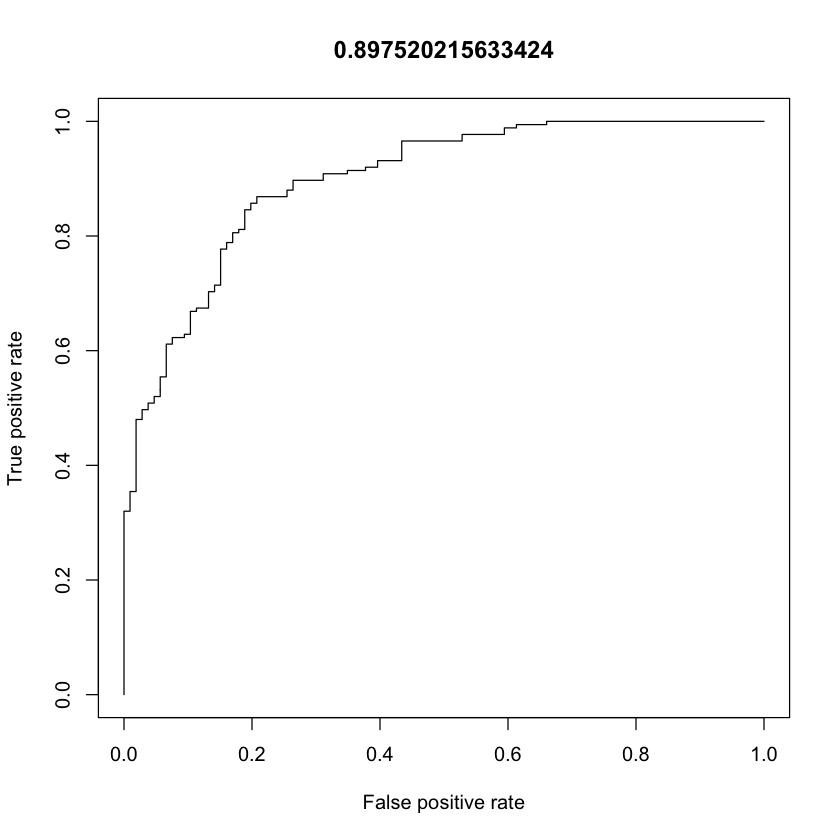

In [48]:
pred_obj <- prediction(pred,df$any_damage)
roc_obj <- performance(pred_obj,measure = "tpr",x.measure = "fpr")
auc_obj <- performance(pred_obj,measure = "auc")
plot(roc_obj,main=paste(auc_obj@y.values[[1]]))

> You don't want to touch the test set until you are ready to lunch a model you are confident about. **Aurelien Geron (2017) **

As we can see, the logit regression model is overfitting badly, so I would do set aside the testset, even there aren't much of samples left.


In [96]:
dim(bio_flt_nzv[trn_id,])

[1] 225 102

In [115]:
build_AUC_linear_models = function(X, y, seed_value=924){
    #
    # Builds (using caret's train function) several of the linear models discussed in
    # this chapter of the book optimizing the area-under-the-curve metric (AUC)
    #
    # X [n samples, n features] needs to have zero variance columns removed (use nearZeroVar to remove them) and
    # linear dependent columns removed (use findLinearCombos to remove them)
    #
    # y [n samples, 1] is a two factor vector of predictions with the FIRST factor corresponding to the event of interest
    #
    # Written by:
    # -- 
    # John L. Weatherwax                2009-04-21
    # 
    # email: wax@alum.mit.edu
    # 
    # Please send comments and especially bug reports to the
    # above email address.
    # Modifiedby:
    #Randall Zoeng@20180921
    #-----

    # Set up the train control arguments so that we can compute the area-under-the-curve:
    #
    ctrl = trainControl( 
        summaryFunction=twoClassSummary, 
        classProbs=T,
        savePredictions = T,
        method="repeatedcv",number=10,repeats=5)

    # Logistic Regression Model:
    #
    set.seed(seed_value)
    glm.classifier = train( X, y, method="glm", metric="ROC", trControl=ctrl )


    # Linear Discriminant Analysis:
    #
    set.seed(seed_value)
    lda.classifier = train( X, y, method="lda", preProc=c("center","scale"), metric="ROC", trControl=ctrl )


    # Partial Least Squares Discriminant Analysis (this can take a very long time on the churn data set):
    #
    set.seed(seed_value)
    plsda.classifier = train( X, y, method="pls", tuneGrid=expand.grid(.ncomp=1:10), preProc=c("center","scale"), metric="ROC", trControl=ctrl )


    # Penalized Methods:
    #
    glmnGrid = expand.grid(.alpha=c(0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0), .lambda=seq( 0.01, 0.2, length=40))
    set.seed(seed_value)
    glmnet.classifier = train( X, y, method="glmnet", tuneGrid=glmnGrid, preProc=c("center","scale"), metric="ROC", trControl=ctrl )


    # Nearest shrunken Centroids:
    #
    nscGrid = expand.grid(.threshold=0:25)
    set.seed(seed_value)
    nsc.classifier = train( X, y, method="pam", tuneGrid=nscGrid, preProc=c("center","scale"), metric="ROC", trControl=ctrl )

    resamps <- resamples(list(GLM = glm.classifier,
                              LDA = lda.classifier,
                              PLSDA = plsda.classifier,
                              GLMNET = glmnet.classifier,
                              NSC = nsc.classifier))

    return(resamps)

}

In [116]:
bio_linear_models <-  build_AUC_linear_models(bio_flt_nzv[trn_id,],any_damage[trn_id])
summary(bio_linear_models)

1


Call:
summary.resamples(object = bio_linear_models)

Models: GLM, LDA, PLSDA, GLMNET, NSC 
Number of resamples: 50 

ROC 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
GLM    0.2410714 0.3761161 0.4751984 0.4891667 0.5753968 0.8174603    0
LDA    0.1517857 0.3809524 0.4335317 0.4517460 0.5173611 0.6825397    0
PLSDA  0.3174603 0.4781746 0.5357143 0.5533532 0.6250000 0.8571429    0
GLMNET 0.2410714 0.4652778 0.5044643 0.5390179 0.6346726 0.8169643    0
NSC    0.3174603 0.4781746 0.5357143 0.5529960 0.6250000 0.8571429    0

Sens 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
GLM    0.3571429 0.5000000 0.5714286 0.5642857 0.6428571 0.9285714    0
LDA    0.3571429 0.5000000 0.6428571 0.6171429 0.7142857 0.8571429    0
PLSDA  0.6428571 0.8571429 0.9285714 0.9128571 1.0000000 1.0000000    0
GLMNET 0.6428571 0.8571429 0.9285714 0.9142857 1.0000000 1.0000000    0
NSC    0.5714286 0.7857143 0.8571429 0.8471429 0.9285714 1.0000000    0

Spec 

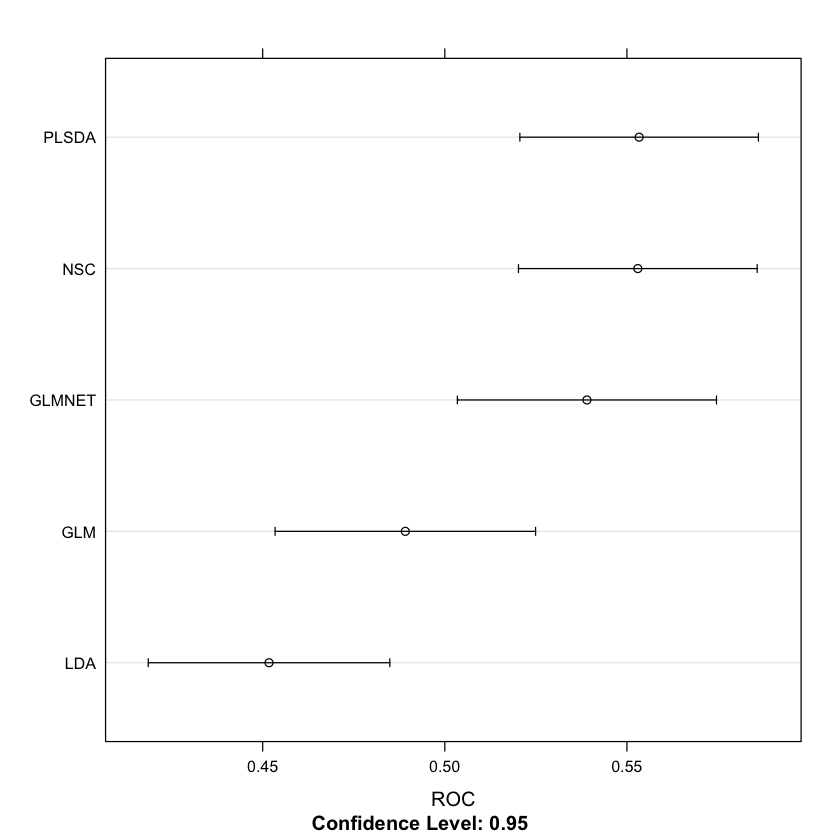

In [117]:
trellis.par.set(caretTheme())
dotplot(bio_linear_models, metric = "ROC")